# Planewave Energy Cut-off and Kpoint Mesh
After the first tutorial covered the electronic convergence of a DFT calculation, the next step is to get a better understanding of the energy cut-off and kpoint mesh, the two primary convergence parameters of a plane wave DFT simulation code. The electronic smearing $\sigma$ would be a third parameter and the density of the mesh for sampling the charge desity a fourth one, but these two are not considered at this point. 

Following the first tutorial again the [SPHInX](https://sxrepo.mpie.de) DFT code is used in combination with [pyiron.org](https://pyiron.org) workflow framework. The installation of these software packages is explained in the first tutorial. In analogy to the first tutorial, also the second tutorial starts by importing the `Project` object in addition to `matplotlib` and `numpy`. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pyiron_atomistics import Project

A new `Project` object is created named `convergence` to separate the calculation from the first and the second tutorial. Any remaining calculation in the `convergence` folder are removed using the `remove_jobs()` function, to provide a fresh start for every execution of the notebook.

In [2]:
pr = Project("convergence")
pr.remove_jobs(recursive=True, silently=True)

0it [00:00, ?it/s]

From the `Project` object an Aluminium bulk structure is again created using the `create.structure.ase.bulk()` function. In contrast to the previous example which used a primitive cell, a cubic cell is created using the `cubic=True` parameter. Afterwards the structure is again visualized using the `plot3d()` function.

In [3]:
structure_Al = pr.create.structure.ase.bulk("Al", cubic=True)
structure_Al.plot3d()

NGLWidget()

While the primitive cell of Aluminium by definition only includes a single Aluminium atom, the cubic cell contains four Aluminium atoms. 

## Planewave Energy Cut-off
While the SPHInX DFT simulation code internally defines the planewave energy cut-off in Hartree pyiron consistently uses electron volt (eV) for the placewave energy cut-off for all DFT simulation codes and also the energies calculated. Beyond eV pyiron uses Angstrom for length, Giga Pascal for pressures and stresses, Kelvin for temperature, femtoseconds for time and atomic mass units for the masses. A full list of the internal units in pyiron is included in the [FAQ](https://pyiron.readthedocs.io/en/latest/source/faq.html#what-units-does-pyiron-use).

For testing different planewave energy cut-offs a `linspace()` is created ranging from 100eV to 600eV in a total of 21 steps which results in a step size of 25eV. 

In [4]:
encut_lst = np.linspace(100,600,21)
encut_lst

array([100., 125., 150., 175., 200., 225., 250., 275., 300., 325., 350.,
       375., 400., 425., 450., 475., 500., 525., 550., 575., 600.])

For each planewave energy cut-off a new SPHInX job object is created with the name consisting of `spx_Al_encut_` and the value of the planewave energy cut-off. The rest follows the same structure as introduced in the previous tutorial. The `structure` object is assigned to the SPHInX job object, the kpoint mesh is set to $2\times2\times2$ and the number of CPU cores is set to one as before. In contrast to the previous example the individual calculation are now nested in a for loop with the total energy being appended to the `energy_tot_encut_lst` at the end of each calculation. 

In [5]:
energy_tot_encut_lst = []
for encut in encut_lst:
    job_Al_conv = pr.create.job.Sphinx("spx_Al_encut_{:.0f}".format(encut))
    job_Al_conv.structure = structure_Al
    job_Al_conv.set_kpoints([2,2,2])
    job_Al_conv.set_encut(encut)
    job_Al_conv.server.cores = 1
    job_Al_conv.run()
    energy_tot_encut_lst.append(job_Al_conv.output.generic.energy_tot[-1])

The job spx_Al_encut_100 was saved and received the ID: 2
The job spx_Al_encut_125 was saved and received the ID: 3
The job spx_Al_encut_150 was saved and received the ID: 4
The job spx_Al_encut_175 was saved and received the ID: 5
The job spx_Al_encut_200 was saved and received the ID: 6
The job spx_Al_encut_225 was saved and received the ID: 7
The job spx_Al_encut_250 was saved and received the ID: 8
The job spx_Al_encut_275 was saved and received the ID: 9
The job spx_Al_encut_300 was saved and received the ID: 10
The job spx_Al_encut_325 was saved and received the ID: 11
The job spx_Al_encut_350 was saved and received the ID: 12
The job spx_Al_encut_375 was saved and received the ID: 13
The job spx_Al_encut_400 was saved and received the ID: 14
The job spx_Al_encut_425 was saved and received the ID: 15
The job spx_Al_encut_450 was saved and received the ID: 16
The job spx_Al_encut_475 was saved and received the ID: 17
The job spx_Al_encut_500 was saved and received the ID: 18
The j

This example highlights a second benefit of a workflow framework like pyiron, iterating over a number of different parameters in the Python programming language is very simple and with the pyiron workflow framework setting up a DFT simulation is as easy as calling a python function. While a loop in the order of 20 configurations can still be managed on the file system or with shell scripts, the same task becomes much more challenging with hundreds or thousands of calculation, espeically when some of these calculation do not converge. 

In analogy to the previous tutorial, the change of energy is plotted over the plane wave energy cutoff. The energy converges monotonously as increasing number of plane waves always results in lower energies. Still some DFT simulation codes like VASP subtract the energy of a single atom in Vaccum from the calculated energy, which can lead to non-monotonous convergence. 

Text(0, 0.5, 'Energy (eV)')

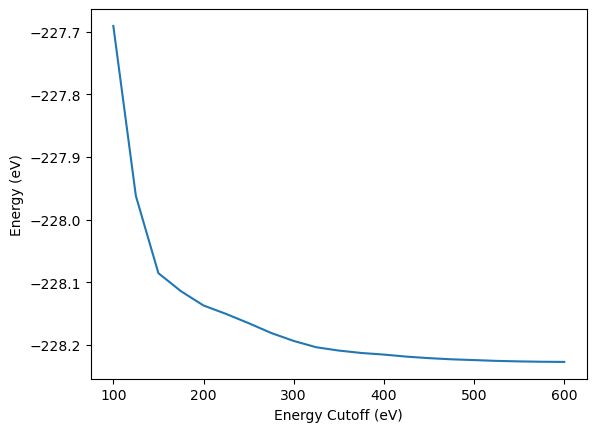

In [6]:
plt.plot(encut_lst, energy_tot_encut_lst)
plt.xlabel("Energy Cutoff (eV)")
plt.ylabel("Energy (eV)")

By plotting the convergence of the absolute difference to energy at maximum planewave energy cutoff on a semi-logarthimic plot, it becomes clear that convergence can only be defined relative to a specific planewave energy cutoff, not in an absolute way. 

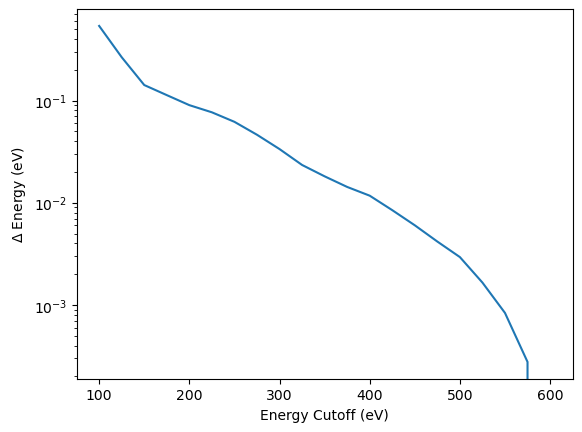

In [7]:
plt.plot(encut_lst, np.array(energy_tot_encut_lst)-energy_tot_encut_lst[-1])
plt.xlabel("Energy Cutoff (eV)")
plt.ylabel("$\Delta$ Energy (eV)")
plt.yscale("log")

For the following calculations a planewave energy cut-off of 300eV is chosen, primarily for computational efficiency. In addition, it is important to mention that the planewave energy cut-off is not universal, it has to be tested for any element and even alloys can have different convergence behaviour depending on their electronic structure. So careful convergence tests should be the start of every DFT calculation. 

## K-point Mesh 
While the planewave energy cut-off limits the number of planewaves to resolve the electronic structure, the k-point mesh represents the sampling in reciprocal space. The finer the k-point mesh the less interpolation is required between the individual k-points to resolve the electronic structure. For the tutorial a kpoint mesh is choosen starting from the Gamma point $1\times1\times1$ up to a mesh with $10\times10\times10$ k-points. 

In [8]:
kpoint_dim_lst = np.arange(1,11)
kpoint_dim_lst

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

It is important to mention that a $10\times10\times10$ k-point mesh typically does not result in 1000 k-points as the crystal symmetry is leveraged to choose high symmetry points and reduce the number of k-points required to calculate. Typically the method from [Monkhorst and Pack](https://doi.org/10.1103/PhysRevB.13.5188) is used to choose high symmetry points. 

Again a for-loop is used to iterate over the k-point mesh dimensions and create a SPHInX calculation for each of those. The rest remains the same to compared to the for-loop to analyse the planewave energy cut-off convergence above. 

In [9]:
energy_tot_kpoint_lst = []
for kpoint in kpoint_dim_lst:
    job_Al_conv = pr.create.job.Sphinx("spx_Al_kpoint_{:.0f}_{:.0f}_{:.0f}".format(kpoint, kpoint, kpoint))
    job_Al_conv.structure = structure_Al
    job_Al_conv.set_kpoints([kpoint,kpoint,kpoint])
    job_Al_conv.set_encut(300.0)
    job_Al_conv.server.cores = 1
    job_Al_conv.run()
    energy_tot_kpoint_lst.append(job_Al_conv.output.generic.energy_tot[-1])

The job spx_Al_kpoint_1_1_1 was saved and received the ID: 23
The job spx_Al_kpoint_2_2_2 was saved and received the ID: 24
The job spx_Al_kpoint_3_3_3 was saved and received the ID: 25
The job spx_Al_kpoint_4_4_4 was saved and received the ID: 26
The job spx_Al_kpoint_5_5_5 was saved and received the ID: 27
The job spx_Al_kpoint_6_6_6 was saved and received the ID: 28
The job spx_Al_kpoint_7_7_7 was saved and received the ID: 29
The job spx_Al_kpoint_8_8_8 was saved and received the ID: 30
The job spx_Al_kpoint_9_9_9 was saved and received the ID: 31
The job spx_Al_kpoint_10_10_10 was saved and received the ID: 32


In contrast to the monotonous convergence of the total energy with increasing planewave energy cut-off, the k-point mesh convergence is not as systematic. Rather it fluctuates around the convergened number at maximum k-point mesh. For simplicity the total number of k-points on the x-axis is just calculated as the product of the k-points in each dimension, not taking into account the reduction in required calculation based on the consideration of the crystal symmetry.

Text(0, 0.5, 'Energy (eV)')

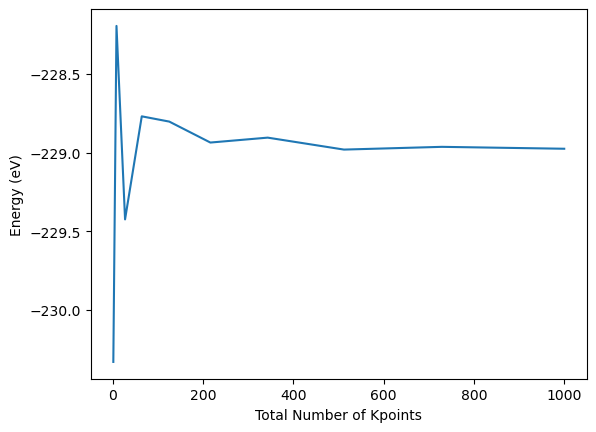

In [10]:
plt.plot([k**3 for k in kpoint_dim_lst], energy_tot_kpoint_lst)
plt.xlabel("Total Number of Kpoints")
plt.ylabel("Energy (eV)")

Once more following the same trick, the convergence can be analysed more efficiently by comparing to the energy at maximum k-point mesh and subtract it from the previous energies and compute the absolute difference. The relative convergence is plotted on a semi-logarithmic scale.

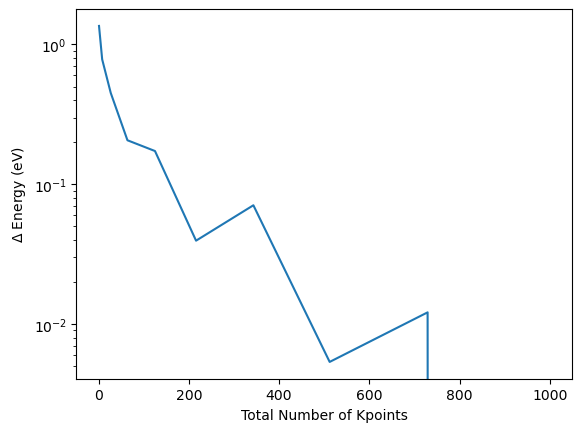

In [11]:
plt.plot([k**3 for k in kpoint_dim_lst], np.abs(np.array(energy_tot_kpoint_lst)-energy_tot_kpoint_lst[-1]))
plt.xlabel("Total Number of Kpoints")
plt.ylabel("$\Delta$ Energy (eV)")
plt.yscale("log")

As the inclusion of the Gamma point drastically impacts the convergence behaviour, the convergence is typically analysed by either considering only the odd or only the even numbers of k-points, e.g. those who include the Gamma point or not. By coloring the odd and even k-points separately this can be demonstrated for the current example:

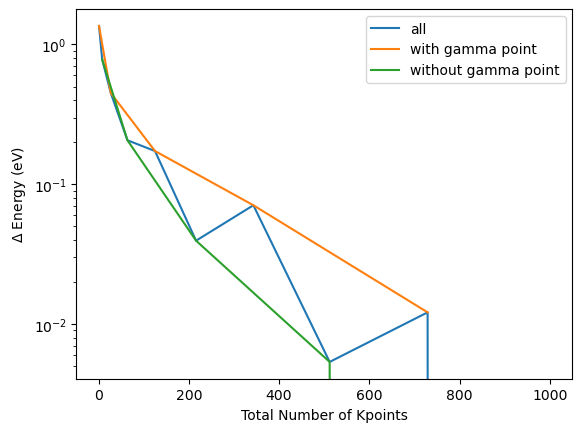

In [12]:
plt.plot([k**3 for k in kpoint_dim_lst], np.abs(np.array(energy_tot_kpoint_lst)-energy_tot_kpoint_lst[-1]), label="all")
plt.plot([k**3 for k in kpoint_dim_lst][::2], np.abs(np.array(energy_tot_kpoint_lst)-energy_tot_kpoint_lst[-1])[::2], label="with gamma point")
plt.plot([k**3 for k in kpoint_dim_lst][1::2], np.abs(np.array(energy_tot_kpoint_lst)-energy_tot_kpoint_lst[-1])[1::2], label="without gamma point")
plt.xlabel("Total Number of Kpoints")
plt.ylabel("$\Delta$ Energy (eV)")
plt.yscale("log")
plt.legend()

## Supercell Size
The previous supercells were both cubic, so the k-point mesh in reciprocal space was also chosen in a way to have the same number of k-points in each reciprocal dimension. Still not all simulation cells are cubic. For the example of a simulation cell which is doubled in z-direction the number of k-points in this direction can be reduced by a factor 1/2. For illustration the resulting supercell is visualized below.

In [13]:
structure_Al.repeat([1,1,2]).plot3d()

NGLWidget()

In analogy to the previous k-point mesh convergence test above the loop iterates over the number of kpoints in one dimension. For this test only the even number of kpoints are considered, so the number of k-points for the z-dimension can be set to be half the number of kpoints in the other dimensions. 

In [14]:
energy_tot_kpoint_big_lst = []
for kpoint in kpoint_dim_lst[1::2]:
    job_Al_conv = pr.create.job.Sphinx("spx_Al_kpoint_big_{:.0f}_{:.0f}_{:.0f}".format(kpoint, kpoint, kpoint/2))
    job_Al_conv.structure = structure_Al.repeat([1,1,2])
    job_Al_conv.set_kpoints([kpoint,kpoint,kpoint/2])
    job_Al_conv.set_encut(300.0)
    job_Al_conv.server.cores = 1
    job_Al_conv.run()
    energy_tot_kpoint_big_lst.append(job_Al_conv.output.generic.energy_tot[-1])

The job spx_Al_kpoint_big_2_2_1 was saved and received the ID: 33
The job spx_Al_kpoint_big_4_4_2 was saved and received the ID: 34
The job spx_Al_kpoint_big_6_6_3 was saved and received the ID: 35
The job spx_Al_kpoint_big_8_8_4 was saved and received the ID: 36
The job spx_Al_kpoint_big_10_10_5 was saved and received the ID: 37


By visualizing the convergence in comparison to the convergence of the smaller supercell which was not repeated in z-direction, the reduced k-point mesh in z-direction leads to the same result. The minor deviations can be accounted to the final reference not being identical. 

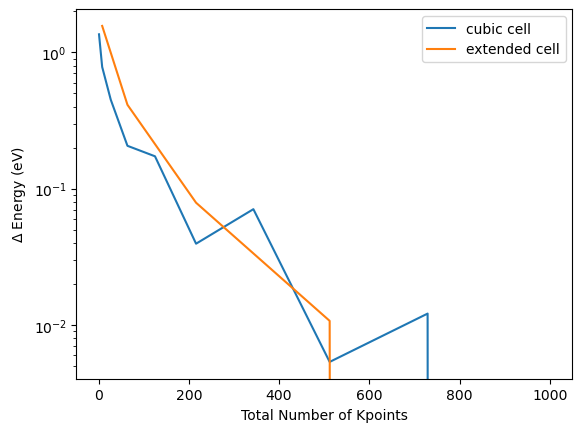

In [15]:
plt.plot([k**3 for k in kpoint_dim_lst], np.abs(np.array(energy_tot_kpoint_lst)-energy_tot_kpoint_lst[-1]), label="cubic cell")
plt.plot([k**3 for k in kpoint_dim_lst][1::2], np.abs(np.array(energy_tot_kpoint_big_lst)-energy_tot_kpoint_big_lst[-1]), label="extended cell")
plt.xlabel("Total Number of Kpoints")
plt.ylabel("$\Delta$ Energy (eV)")
plt.yscale("log")
plt.legend()

As the k-point mesh is defined in reciprocal space, you can achieve the same level of precision by doubling the simulation cell in one direction and setting the k-point mesh to half. Still the additional interaction of the electrons results in this simulation being less efficient, so the computationally most efficient choice for a DFT simulation is choosing the simulation cell as small as possible, but that might restrict the scientific complexity. 

## Conclusion
While the accuracy of most DFT calculation is limited by the choice of DFT functional, the precision can also be the dominant source of uncertainty. The precision is primarily related to the planewave energy cut-off and k-point mesh. 